In [1]:
using LinearAlgebra, Random, Combinatorics, Plots, Distributions

In [2]:
##################################################
### Handles pivots that are numerically 0 or 1 ### 
### but over 1 or less than 0.                 ###
### EX) input -1e-10 then returns 0            ###     
##################################################
function preprocess_pivot(a, tol)
    if abs(imag(a))>tol
        println("Imaginary pivot detected")
        return false, a
    end
    if real(a)>1 ### Handles the case where pivot = 1+ϵ
        if (real(a)-1)<tol
            return true, 1
        else
            println("Pivot > 1")
            return false, a
        end
    end
    if real(a)<0 ### Handles the case where pivot = -ϵ
        if abs(real(a))<tol
            return true, 0
        else
            println("Pivot < 0")
            return false, a
        end
    end
    return true, real(a)
end    
        
function sampleDPP(K; tol=1e-14) # Poulson's algorithm
    A = copy(K)
    sample = zeros(Int, size(K,1))
    sidx = 1
    n = size(K, 1)
    for j in 1:n
        f, p = preprocess_pivot(A[j,j], tol)
        if f==false @show j, sample, p end # If pivot is not valid
        
        A[j,j] = p + 0.0*im
        if   rand(Bernoulli(p)) sample[sidx] = j; sidx+=1 
        else A[j,j] -= 1 
        end
        view(A, j+1:n, j+1:n) .-= view(A,j+1:n, j) / A[j, j] * transpose(view(A,j,j+1:n)) 
    end
    return sample[1:sidx-1]
end    

sampleDPP (generic function with 1 method)

In [3]:
## MAIN IMPLEMENTATION SOURCE = https://arxiv.org/pdf/1212.5414.pdf

# Note : BLUE-RED particles are not relevant to the implementation
function bw_coordinates(n) 
    # Given n, return b, w coordinates
    # Particle coordinates are according to Figure 3
    B = [ [2i-2,2j-1] for i in 1:n+1, j in 1:n ][:]
    W = [ [2i-1,2j-2] for i in 1:n, j in 1:n+1 ][:]
    return B, W
end
function edge_ind(n) 
    # Returns edge information with W-B idx
    # Edge orders : West n^2 -> east n^2 -> south n^2 -> north n^2
    # For example if an edge is b[10]-w[9] then it is expressed as [9, 10]
    all_id = 1:n^2+n
    edge_w = collect(zip(1:n^2,     all_id[(all_id.%(n+1)).!=0]))
    edge_e = collect(zip(n+1:n^2+n, all_id[(all_id.%(n+1)).!=1]))
    edge_s = collect(zip(1:n^2,     all_id[(all_id.%(n+1)).!=1]))
    edge_n = collect(zip(n+1:n^2+n, all_id[(all_id.%(n+1)).!=0]))
    return [edge_w; edge_e; edge_s; edge_n]
end
function Kasteleyn(n)
    # Compute Kasteleyn matrix from Eq (2.11)
    # K[i, j] = K(B[i], W[j])
    # a = 1 for us
    b, w = bw_coordinates(n)
    e = edge_ind(n)    
    K = im*zeros(Int, n^2+n, n^2+n)
    for i in 1:length(e)
        b_coord, w_coord = b[e[i][2]], w[e[i][1]]
        p = (sum(b_coord)-1)÷2 # p = (x1+x2-1)/2
        wmb = w_coord - b_coord
        if     wmb==[1,1]   K[e[i][2], e[i][1]]+=(-1)^p         # l=0, e1
        elseif wmb==[-1,-1] K[e[i][2], e[i][1]]+=(-1)^(p+1)     # l=1, e1
        elseif wmb==[-1,1]  K[e[i][2], e[i][1]]+=im*(-1)^(p+1)  # l=1, e2
        elseif wmb==[1,-1]  K[e[i][2], e[i][1]]+=im*(-1)^p      # l=0, e2 
        end
    end
    return K, b, w, e
end
function kernel_aztec(n)
    # Create L matrix, which is our K-kernel of the DPP
    # Formula given in Eq (2.12)
    K, b, w, e = Kasteleyn(n)
    invK = inv(K)
    L = zeros(length(e), length(e))*im
    for i in 1:length(e), j in 1:length(e)
        wi, bi = e[i][1], e[i][2]
        wj, bj = e[j][1], e[i][2]
        L[i,j] = K[bi, wi] * invK[wj, bi]
    end
    return L
end 

rect(xy, wh) = Shape(xy[1].+[0,wh[1],wh[1],0], xy[2].+[0,0,wh[2],wh[2]])
c_codes = [:white, :red, :blue, :yellow, :green]
function bw_upright(n) 
    ## Coordinate system to put aztec diamond inside [0, 2n] x [0, 2n]
    ## Use this coordinate system for drawing Aztec diamond
    b, w = bw_coordinates(n)
    return map(x->[n+(x[2]-x[1]+1)÷2, (x[1]+x[2]+1)÷2], b), map(x->[n+(x[2]-x[1]+1)÷2, (x[1]+x[2]+1)÷2], w)
end    

#######################################################
### Samples DPP from Aztec diamond kernel and draws ###
### Aztec diamond plot with heatmap and Shape       ###
#######################################################
function aztec_diamonds_DPP(K, n; tol=1e-14)
    s = sampleDPP(K; tol=tol)
    b, w = bw_upright(n)
    eidx = edge_ind(n)
    domino_colors = zeros(Int, 2n, 2n)
    rect_lines = Shape{Float64, Float64}[]
    cornershifts = [[-1/2,-1/2], [-1/2,-3/2], [-1/2, -1/2], [-3/2, -1/2]]
    rectsizes = [[1,2], [1,2], [2,1], [2,1]]
    
    for i in 1:length(s)
        wi, bi = eidx[s[i]]
        c = (s[i]-1)÷(n^2)+1 # c = 1, 2, 3, 4 is an indicator for W, E, S, N, repsectively
        domino_colors[b[bi]...] = c
        domino_colors[w[wi]...] = c
        push!(rect_lines, rect((reverse(w[wi])+cornershifts[c]), rectsizes[c]))
    end
    return domino_colors, rect_lines
end

aztec_diamonds_DPP (generic function with 1 method)

In [4]:
n = 20
K = kernel_aztec(n)
size(K)

(1600, 1600)

In [6]:
@time dc, rl = aztec_diamonds_DPP(K, n; tol=1e-10);

  2.057634 seconds (10.43 k allocations: 20.384 GiB, 5.39% gc time)


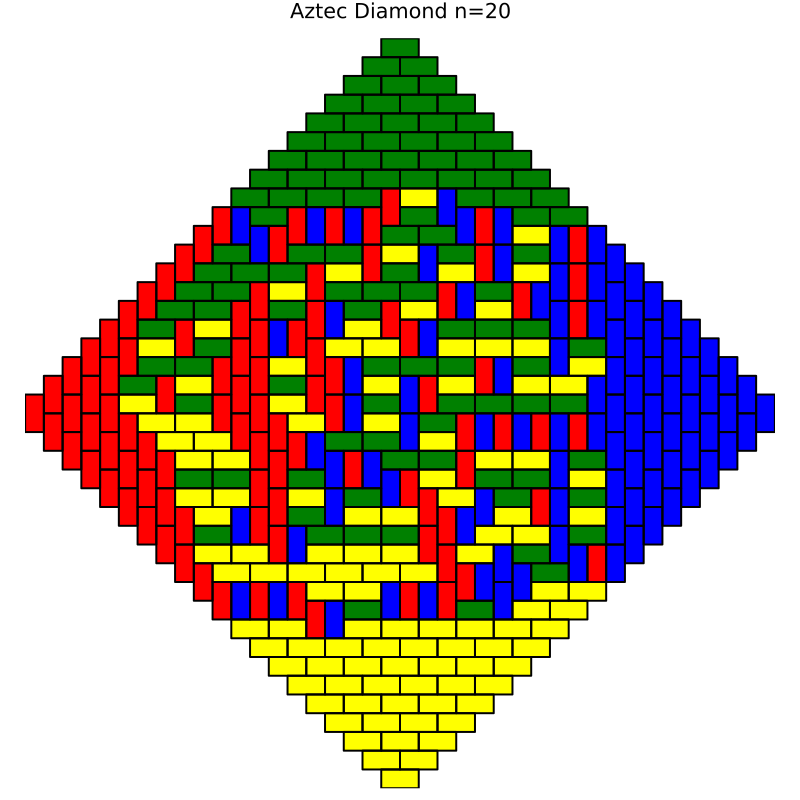

In [7]:
heatmap(dc, leg=false, title="Aztec Diamond n=$n", color=c_codes, 
                    aspect_ratio=1, xlims=(1/2,2n+1/2), ylims=(1/2,2n+1/2), 
                    showaxis=false, tick=false, size=(800, 800))
plot!(rl, legend=false, color=:transparent, linewidth=2, aspectratio=1)